In [53]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import scipy
import scipy.stats as st
from statsmodels.tsa.seasonal import STL
from scipy import signal
import pingouin as pg

# loading news and data

In [23]:
total_news = pd.read_csv('data/total_news_without_dupl.csv', sep=";",infer_datetime_format=True)
# total_news['date'].astype('datetime64')
total_news["date"]= pd.to_datetime(total_news["date"])
total_news.head()

,date,title,summary
0,2014-12-31,"Standouts in Tech: Drones, Virtual Reality, In...",Farhad Manjoo picks four products from 2014 th...
1,2015-01-01,Digital Tax Increase to Take Effect in Europe,New rules are coming into force for services l...
2,2015-01-01,Web Freedom Is Seen as a Growing Global Issue,The new year promises further attempts at onli...
3,2015-02-01,A Day With Apple Pay,The success of Apple Pay will in part be deter...
4,2015-02-01,Daily Report: Web Freedom Is Seen as a Growing...,The new year promises further attempts at onli...


In [157]:
spx_index = DataReader('^GSPC', 'yahoo', '2014-12-30', '2022-01-09')['Adj Close']
spx_returns = spx_index.pct_change().dropna()
spx_returns

Date
2014-12-31   -0.010311
2015-01-02   -0.000340
2015-01-05   -0.018278
2015-01-06   -0.008893
2015-01-07    0.011630
                ...   
2022-01-03    0.006374
2022-01-04   -0.000630
2022-01-05   -0.019393
2022-01-06   -0.000964
2022-01-07   -0.004050
Name: Adj Close, Length: 1769, dtype: float64

# Data density and distribution functions

<AxesSubplot:ylabel='Density'>

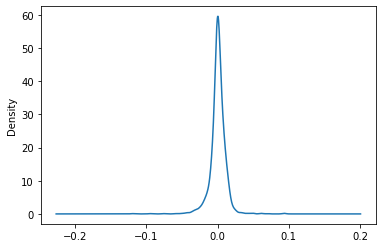

In [25]:
spx_returns.plot(kind='kde')

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   2.,   1.,   0.,   1.,   0.,   1.,   0.,
          1.,   1.,   2.,   3.,   2.,   1.,   3.,   4.,   2.,   2.,   2.,
          4.,   7.,   2.,   4.,   9.,   3.,   8.,  11.,   8.,  11.,  13.,
         14.,  13.,  17.,  16.,  23.,  41.,  39.,  42.,  52.,  60.,  83.,
        126., 142., 129., 139.,  97.,  89.,  76.,  58.,  55.,  58.,  44.,
         31.,  43.,  29.,  26.,  24.,  16.,  18.,  10.,   5.,   4.,   4.,
          5.,   3.,   3.,   2.,   1.,   3.,   0.,   0.,   1.,   1.,   0.,
          1.,   2.,   0.,   0.,   0., 

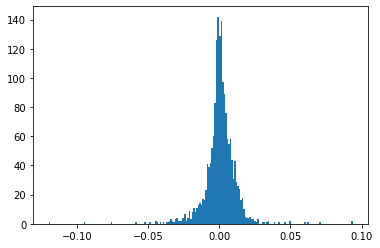

In [26]:
plt.hist(spx_returns, bins=200)

In [27]:
# scipy.stats.normaltest(spx_returns)
rng = np.random.default_rng()
k2, p = st.normaltest(spx_returns)
alpha = 1e-3
print("p = {:g}".format(p))
p = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 7.29083e-121
The null hypothesis cannot be rejected


# Confidence interval without considering trend influence

In [28]:
conf_int = st.t.interval(alpha=0.95, df=len(spx_returns)-1, loc=np.mean(spx_returns), scale=st.sem(spx_returns))
conf_int

(-5.192525510000967e-06, 0.0010500235317182683)

In [29]:
outliers_negative = spx_returns[spx_returns <= conf_int[0]]
outliers_positive = spx_returns[spx_returns >= conf_int[1]]
outliers = pd.concat([outliers_negative, outliers_positive], ignore_index=False)
outliers

Date
2014-12-31   -0.010311
2015-01-02   -0.000340
2015-01-05   -0.018278
2015-01-06   -0.008893
2015-01-09   -0.008404
                ...   
2021-12-22    0.010180
2021-12-23    0.006224
2021-12-27    0.013839
2021-12-29    0.001402
2022-01-03    0.006374
Name: Adj Close, Length: 1643, dtype: float64

In [161]:
spx_returns_date = spx_returns.reset_index(drop=False)
spx_index_date = spx_index.reset_index(drop=False)
spx_index_date.columns

Index(['Date', 'Adj Close'], dtype='object')

# Seasonality and trend decomposition with STL

In [179]:
stl = STL(spx_returns_date['Adj Close'], period=12)
returns_stl_result = stl.fit()

In [180]:
seasonal, trend, resid = returns_stl_result.seasonal, returns_stl_result.trend, returns_stl_result.resid

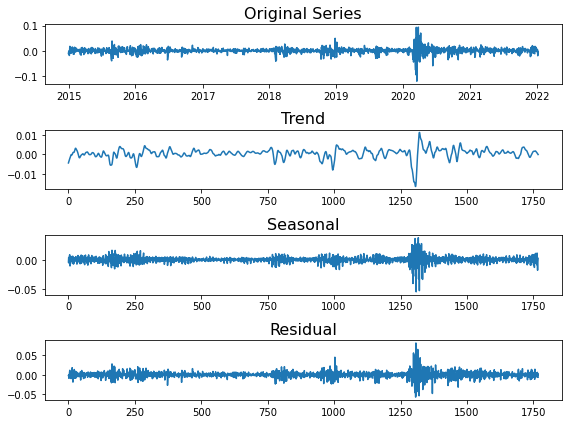

In [181]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(spx_returns)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

# Detrending returns

<AxesSubplot:>

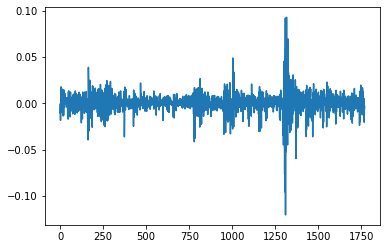

In [147]:
detrended = signal.detrend(spx_returns)
detrended_spx_returns = pd.DataFrame(detrended, columns = ['return'])
detrended_spx_returns['date'] = spx_returns_date['Date'].copy()
detrended_spx_returns['return'].plot()

# Detrending prices and calculating returns afterwards

<AxesSubplot:xlabel='Date'>

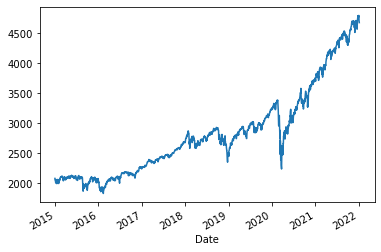

In [182]:
spx_index.plot()

<AxesSubplot:>

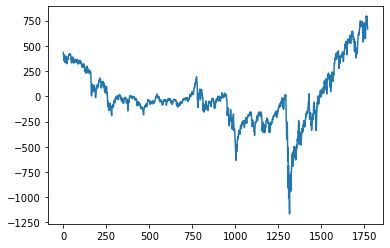

In [166]:
detrended = signal.detrend(spx_index)
detrended_spx_index = pd.DataFrame(detrended, columns = ['return'])
detrended_spx_index['return'].plot()

        return       date
1    -0.052313 2014-12-31
2    -0.004934 2015-01-02
3    -0.094839 2015-01-05
4    -0.051927 2015-01-06
5     0.062278 2015-01-07
...        ...        ...
1765  0.038058 2022-01-03
1766 -0.005500 2022-01-04
1767 -0.119696 2022-01-05
1768 -0.008460 2022-01-06
1769 -0.029604 2022-01-07

[1769 rows x 2 columns]


<AxesSubplot:>

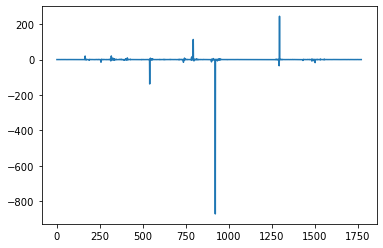

In [175]:
detrended_index_spx_returns = detrended_spx_index.pct_change().dropna()
detrended_index_spx_returns['date'] = spx_index_date['Date'].copy()
print(detrended_index_spx_returns)
detrended_index_spx_returns['return'].plot()

# Looking for anomalies in n days intervals

In [244]:
#n - количества дней по каждую сторону от выбранной даты
from statsmodels.stats.weightstats import ttest_ind
n = 30
df = pd.DataFrame(0, index=np.arange(len(spx_returns-(2*n-1))), columns=['p-val', 'date', 'conf_int_lower', 'conf_int_upper', 'return'])
# df.loc[0:len(detrended_spx_returns)-(2*n-1), 'p-val'] = 0
# print(len(detrended_spx_returns), len(df))
for i in range(n, len(df)):
    n_pred = spx_returns[i - n:i - 1]
    n_post = spx_returns[i:i + (n - 1)]
    n_concat = pd.concat([n_pred, n_post])
    results = ttest_ind(n_pred,n_post)
#     print(results[1].item(0))
#     df.iloc[0, 0] = results[1].item(0)
#     print(df)
    df.iloc[i-n, 0] = results[1].item(0)
    df.iloc[i-n, 1] = spx_returns_date.iloc[i, 0]
    conf_int_10days = st.t.interval(alpha=0.95, df=len(n_concat)-1, loc=np.mean(n_concat), scale=st.sem(n_concat))
    df.iloc[i-n, 2] = conf_int_10days[0]
    df.iloc[i-n, 3] = conf_int_10days[1]
    df.iloc[i-n, 4] = spx_returns[i]

p_values_spx = df[:-n]
print(p_values_spx)
    
n_days_analysis_anom = p_values_spx[p_values_spx['p-val'] <= 0.05][['return', 'conf_int_lower', 'conf_int_upper', 'date']]
print(n_days_analysis_anom)

         p-val                 date  conf_int_lower  conf_int_upper    return
0     0.877540  2015-02-13 00:00:00       -0.002673        0.002017  0.004075
1     0.638254  2015-02-17 00:00:00       -0.002354        0.002327  0.001598
2     0.709327  2015-02-18 00:00:00       -0.002136        0.002628 -0.000314
3     0.421832  2015-02-19 00:00:00       -0.001871        0.002757 -0.001062
4     0.326099  2015-02-20 00:00:00       -0.001755        0.002836  0.006127
...        ...                  ...             ...             ...       ...
1734  0.413837  2022-01-03 00:00:00       -0.003791        0.003918  0.006374
1735  0.261526  2022-01-04 00:00:00       -0.004264        0.003644 -0.000630
1736  0.201754  2022-01-05 00:00:00       -0.004163        0.004049 -0.019393
1737  0.681767  2022-01-06 00:00:00       -0.003381        0.004680 -0.000964
1738  0.732512  2022-01-07 00:00:00       -0.004388        0.004391 -0.004050

[1739 rows x 5 columns]
        return  conf_int_lower  conf_in

# Looking for anomalies via looking at data distribution (2 st devs)

In [236]:
# detrended returns - FOR COMPARISON
spx_returns_mu_detrend = detrended_spx_returns.mean()
spx_returns_dev_detrend = detrended_spx_returns.std()

lower_detrend = spx_returns_mu_detrend - 2*spx_returns_dev_detrend
upper_detrend = spx_returns_mu_detrend + 2*spx_returns_dev_detrend
print(spx_returns_mu_detrend, [lower_detrend[1], upper_detrend[1]])

return   -3.005612e-19
dtype: float64 [-0.02262190615584055, 0.02262190615584055]


In [252]:
lower_anom_detrend = detrended_spx_returns[detrended_spx_returns['return'] <= lower_detrend[1]][['date', 'return']]
upper_anom_detrend = detrended_spx_returns[detrended_spx_returns['return'] >= upper_detrend[1]][['date', 'return']]
spx_anom_95_detrend = pd.concat([lower_anom_detrend, upper_anom_detrend])
spx_anom_95_detrend

,date,return
161,2015-08-21,-0.031981
162,2015-08-24,-0.039544
168,2015-09-01,-0.029710
186,2015-09-28,-0.025809
256,2016-01-07,-0.023882
...,...,...
1332,2020-04-17,0.026028
1340,2020-04-29,0.025814
1353,2020-05-18,0.030724
1366,2020-06-05,0.025427


In [245]:
# non-detrended returns - SEEMS TO BE MORE ACCURATE
spx_returns_mu = spx_returns_date['Adj Close'].mean()
spx_returns_dev = spx_returns_date['Adj Close'].std()

lower = spx_returns_mu - 2*spx_returns_dev
upper = spx_returns_mu + 2*spx_returns_dev
print(spx_returns_mu, [lower, upper])

0.0005224155031041337 [-0.02210629478931977, 0.023151125795528037]


In [246]:
lower_anom = spx_returns_date[spx_returns_date['Adj Close'] <= lower][['Date', 'Adj Close']]
upper_anom = spx_returns_date[spx_returns_date['Adj Close'] >= upper][['Date', 'Adj Close']]
spx_anom_95 = pd.concat([lower_anom, upper_anom])
spx_anom_95


,Date,Adj Close
161,2015-08-21,-0.031851
162,2015-08-24,-0.039414
168,2015-09-01,-0.029576
186,2015-09-28,-0.025666
256,2016-01-07,-0.023700
...,...,...
1332,2020-04-17,0.026794
1340,2020-04-29,0.026584
1353,2020-05-18,0.031501
1366,2020-06-05,0.026212


In [247]:
df = pd.DataFrame()
df['cond_conf_interval'] = spx_anom_95['Date'].reset_index(drop=True)
df['cond_n_days'] = n_days_analysis_anom['date'].reset_index(drop=True)
print(df)

   cond_conf_interval cond_n_days
0          2015-08-21  2016-02-09
1          2015-08-24  2016-02-10
2          2015-09-01  2016-02-11
3          2015-09-28  2016-02-12
4          2016-01-07  2016-02-16
..                ...         ...
67         2020-04-17         NaT
68         2020-04-29         NaT
69         2020-05-18         NaT
70         2020-06-05         NaT
71         2021-03-01         NaT

[72 rows x 2 columns]


In [250]:
np.where(df.cond_conf_interval == df.cond_n_days)

(array([], dtype=int64),)

In [249]:
# two methods show different results..